In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.decomposition import PCA

In [2]:
def load_mnist_data(train_batch_size, test_batch_size):
    # Define the transformations for the MNIST dataset
    transform = transforms.Compose([
        transforms.ToTensor()
    ])
    training_set = datasets.MNIST(root='data', train=True, download=True, transform=transform)
    train_loader = torch.utils.data.DataLoader(training_set, batch_size=train_batch_size, shuffle=True)
    
    testing_set = datasets.MNIST(root='data', train=False, download=True, transform=transform)
    test_loader = torch.utils.data.DataLoader(testing_set, batch_size=test_batch_size, shuffle=True)

    return train_loader, test_loader


In [3]:
train_batch_size = 1000
test_batch_size = 1000

# Load the data
train_loader, test_loader = load_mnist_data(train_batch_size, test_batch_size)

# Initialize arrays to store loss and accuracy values
train_loss_arr = []
test_loss_arr = []
train_acc_arr = []
test_acc_arr = []


In [4]:
class simpleNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Linear(784, 10)
        self.layer2 = nn.Linear(10, 20)   
        self.layer3 = nn.Linear(20, 10)   

    def forward(self, input_tensor):
        input_tensor = F.relu(self.layer1(input_tensor)) 
        input_tensor = F.relu(self.layer2(input_tensor)) 
        output_tensor = self.layer3(input_tensor)         
        return output_tensor


In [5]:
def calculate_loss(model, data_loader, loss_function):
    correct_predictions = 0
    total_samples = 0
    total_loss = 0
    batch_count = 0
    
    with torch.no_grad():
        for batch in data_loader:
            input_data, output_data = batch
            predictions = model(input_data.view(-1, 784))
            loss = loss_function(predictions, output_data)
            total_loss += loss
            batch_count += 1
            
            # Calculate the number of correct predictions
            for i, pred_tensor in enumerate(predictions):
                if torch.argmax(pred_tensor) == output_data[i]:
                    correct_predictions += 1
                total_samples += 1

    return total_loss / batch_count, round(correct_predictions / total_samples, 3)


In [6]:
# Train function
def train_model(model, num_epochs, optimizer, train_loader, test_loader, loss_fn):
    model.train()
    weights_df = pd.DataFrame()

    for epoch in range(num_epochs):
        for batch_idx, (input_data, output_data) in enumerate(train_loader):
            input_data, output_data = Variable(input_data), Variable(output_data)

            optimizer.zero_grad()
            predictions = model(input_data.view(-1, 784))
            loss = loss_fn(predictions, output_data)
            loss.backward()
            optimizer.step()

        epoch_weights_df = pd.DataFrame()
        for name, parameter in model.named_parameters():
            if 'weight' in name:
                weights = torch.nn.utils.parameters_to_vector(parameter).detach().numpy() 
                epoch_weights_df = pd.concat([epoch_weights_df, pd.DataFrame(weights).T], axis=1)
        weights_df = pd.concat([weights_df, epoch_weights_df], axis=0)

        train_loss, train_acc = calculate_loss(model, train_loader, loss_fn)
        test_loss, test_acc = calculate_loss(model, test_loader, loss_fn)

        train_loss_arr.append(train_loss)
        test_loss_arr.append(test_loss)
        train_acc_arr.append(train_acc)
        test_acc_arr.append(test_acc)

        print(f'Epoch [{epoch + 1}/{num_epochs}], Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, '
              f'Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}%')

    return weights_df


In [7]:
max_epochs = 45
combined_df = pd.DataFrame()
df_list = []

loss_function = nn.CrossEntropyLoss()
train_loader, test_loader = load_mnist_data(train_batch_size=64, test_batch_size=1000)

for iteration in range(8):
    print(f"Time: {iteration}")
    model_instance = simpleNN()
    optimizer = torch.optim.Adam(model_instance.parameters(), lr=0.0004, weight_decay=1e-4)
    
    temp_df = train_model(model_instance, max_epochs, optimizer, train_loader, test_loader, loss_function)
    
    df_list.append(temp_df)

combined_df = pd.concat(df_list, ignore_index=True)

print(combined_df)



Time: 0
Epoch [1/45], Train Loss: 0.4547, Train Acc: 0.87%, Test Loss: 0.4422, Test Acc: 0.88%
Epoch [2/45], Train Loss: 0.3525, Train Acc: 0.90%, Test Loss: 0.3443, Test Acc: 0.90%
Epoch [3/45], Train Loss: 0.3198, Train Acc: 0.91%, Test Loss: 0.3140, Test Acc: 0.91%
Epoch [4/45], Train Loss: 0.3006, Train Acc: 0.91%, Test Loss: 0.2970, Test Acc: 0.91%
Epoch [5/45], Train Loss: 0.2831, Train Acc: 0.92%, Test Loss: 0.2805, Test Acc: 0.92%
Epoch [6/45], Train Loss: 0.2719, Train Acc: 0.92%, Test Loss: 0.2713, Test Acc: 0.92%
Epoch [7/45], Train Loss: 0.2601, Train Acc: 0.93%, Test Loss: 0.2615, Test Acc: 0.93%
Epoch [8/45], Train Loss: 0.2533, Train Acc: 0.93%, Test Loss: 0.2560, Test Acc: 0.93%
Epoch [9/45], Train Loss: 0.2463, Train Acc: 0.93%, Test Loss: 0.2534, Test Acc: 0.93%
Epoch [10/45], Train Loss: 0.2347, Train Acc: 0.93%, Test Loss: 0.2413, Test Acc: 0.93%
Epoch [11/45], Train Loss: 0.2280, Train Acc: 0.93%, Test Loss: 0.2373, Test Acc: 0.93%
Epoch [12/45], Train Loss: 0.2236

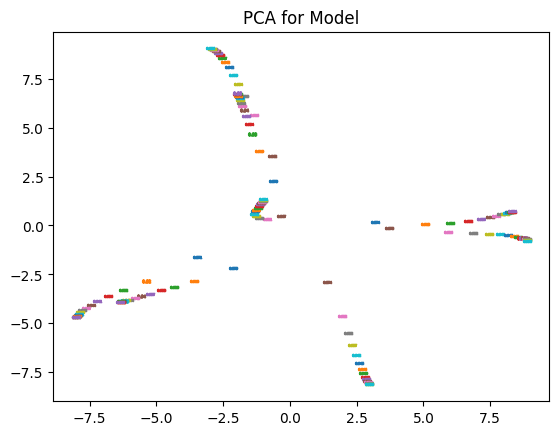

In [8]:
df = combined_df.select_dtypes(include=[np.number])
df_array = np.array(df)

pca = PCA(n_components=2)
new_data = pca.fit_transform(df_array)

df_pca = pd.DataFrame(new_data, columns=['x', 'y'])
df_pca['Accuracy'] = train_acc_arr[:len(df_pca)]
df_pca['Loss'] = train_loss_arr[:len(df_pca)]

final_df = df_pca.iloc[::3, :]

for i in range(len(final_df)):
    accuracy_value = list(final_df['Accuracy'])[i]
    plt.scatter(final_df['x'].iloc[i], final_df['y'].iloc[i], marker=f'${accuracy_value}$')
    plt.title("PCA for Model")

plt.show()


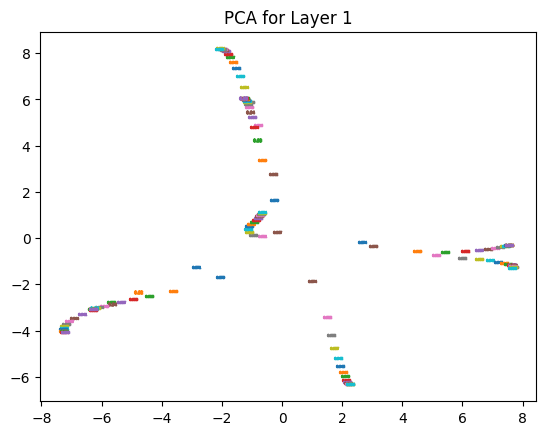

In [9]:
layer_1 = combined_df.iloc[:, 0:7840]
df = np.array(layer_1)
pca = PCA(n_components=2)
new_data = pca.fit_transform(df)
df_pca = pd.DataFrame(new_data, columns=['x', 'y'])
df_pca['Accuracy'] = train_acc_arr[:len(df_pca)]
df_pca['Loss'] = train_loss_arr[:len(df_pca)]
final_df = df_pca.iloc[::3, :]

for i in range(len(final_df)):
    m = final_df['Accuracy'].iloc[i]
    plt.scatter(final_df['x'].iloc[i], final_df['y'].iloc[i], marker=f'${m}$')
    plt.title("PCA for Layer 1")

plt.show()
